In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def load_skeleton_data(directory):
    files = [f for f in os.listdir(directory) if f.endswith('.json')]
    data = []
    for f in files:
        with open(os.path.join(directory, f), 'r') as file:
            data.append(json.load(file))
    return data, files
dataset_dir = '../datasets/mm-fit/skeleton/json_raw/'
directories = []
with os.scandir(dataset_dir) as entries:
    for entry in entries:
        if entry.is_dir():
            directories.append(entry.name)

# samples = []
# files = []
# # do we really need to load this?? there is another process directory function
# for dir_name in directories:
#     data, file = load_skeleton_data(dataset_dir + dir_name)
#     samples.append(data)
#     files.append(file)
#     print(f"Loaded {len(data)} {dir_name} files.")


In [3]:
def get_subject_id(filename):
    return filename.split('_')[0]

def skeleton_to_numpy(frames):
    """Converts list of frames to a numpy array of shape (num_frames, 33, 4)"""
    num_frames = len(frames)
    arr = np.zeros((num_frames, 33, 4))
    for i, frame in enumerate(frames):
        for j, lm in enumerate(frame['landmarks']):
            arr[i, j, 0] = lm['x']
            arr[i, j, 1] = lm['y']
            arr[i, j, 2] = lm['z']
            arr[i, j, 3] = lm['visibility']
    return arr

def smooth_skeleton(skeleton_arr, window_size=5): # test without this
    """
    Applies moving average smoothing to (num_frames, 33, 4) array
    """
    smoothed = skeleton_arr.copy()
    num_frames = skeleton_arr.shape[0]
    if num_frames < window_size:
        return smoothed
        
    for i in range(33): # Each landmark
        for j in range(3): # x, y, z
            smoothed[:, i, j] = pd.Series(skeleton_arr[:, i, j]).rolling(window=window_size, center=True, min_periods=1).mean()
            
    return smoothed

def normalize_skeleton(skeleton_arr): # do we really need normalization if we are extracting angles anyway??
    """
    Normalizes a skeleton array of shape (num_frames, 33, 4).
    1. Spatial: Midpoint between hips at (0,0,0)
    2. Scale: Distance between shoulders = 1
    """
    normalized = skeleton_arr.copy()
    
    for i in range(len(normalized)):
        # Landmark 23: Left Hip, 24: Right Hip
        left_hip = normalized[i, 23, :3]
        right_hip = normalized[i, 24, :3] # what if the hip is not visible? this will break!!
        hip_center = (left_hip + right_hip) / 2.0
        
        # Spatial Normalization
        normalized[i, :, :3] -= hip_center
        
        # Scale Normalization
        # Landmark 11: Left Shoulder, 12: Right Shoulder
        left_sh = normalized[i, 11, :3]
        right_sh = normalized[i, 12, :3]
        shoulder_dist = np.linalg.norm(left_sh - right_sh)
        
        if shoulder_dist > 0:
            normalized[i, :, :3] /= shoulder_dist
            
    return normalized

In [4]:
def calculate_angle(a, b, c):
    """Calculates the angle abc in degrees"""
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    
    ba = a - b
    bc = c - b
    
    # Add epsilon to avoid division by zero
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    
    return np.degrees(angle)

def extract_features_from_clip(normalized_arr, window_size=5):
    """
    Extracts features from a full clip (num_frames, 33, 4)
    Including temporal features (velocity, acceleration) and rolling std
    """
    num_frames = len(normalized_arr)
    L_SHOULDER, R_SHOULDER = 11, 12
    L_ELBOW, R_ELBOW = 13, 14
    L_WRIST, R_WRIST = 15, 16
    L_HIP, R_HIP = 23, 24
    
    features_list = []
    
    # 1. Base geometric features (angles and relative distances)
    for i in range(num_frames):
        frame_lm = normalized_arr[i]
        
        l_elbow_angle = calculate_angle(frame_lm[L_SHOULDER, :3], frame_lm[L_ELBOW, :3], frame_lm[L_WRIST, :3])
        r_elbow_angle = calculate_angle(frame_lm[R_SHOULDER, :3], frame_lm[R_ELBOW, :3], frame_lm[R_WRIST, :3])
        
        l_shoulder_angle = calculate_angle(frame_lm[L_HIP, :3], frame_lm[L_SHOULDER, :3], frame_lm[L_ELBOW, :3])
        r_shoulder_angle = calculate_angle(frame_lm[R_HIP, :3], frame_lm[R_SHOULDER, :3], frame_lm[R_ELBOW, :3])
        
        l_wrist_y_rel = frame_lm[L_WRIST, 1] - frame_lm[L_SHOULDER, 1]
        r_wrist_y_rel = frame_lm[R_WRIST, 1] - frame_lm[R_SHOULDER, 1]
        
        features_list.append([l_elbow_angle, r_elbow_angle, l_shoulder_angle, r_shoulder_angle, l_wrist_y_rel, r_wrist_y_rel])
        
    df_feat = pd.DataFrame(features_list, columns=['l_elbow_angle', 'r_elbow_angle', 'l_shoulder_angle', 'r_shoulder_angle', 'l_wrist_y_rel', 'r_wrist_y_rel'])
    
    # 2. Temporal features for arm landmarks
    ARM_LMS = {
        'l_sh': 11, 'r_sh': 12, 
        'l_el': 13, 'r_el': 14, 
        'l_wr': 15, 'r_wr': 16
    }
    
    for name, idx in ARM_LMS.items():
        # Extract x, y, z for this landmark across all frames
        coords = normalized_arr[:, idx, :3]
        df_coords = pd.DataFrame(coords, columns=[f'{name}_x', f'{name}_y', f'{name}_z'])
        
        # Velocity
        df_vel = df_coords.diff().fillna(0)
        df_vel.columns = [f'{name}_vx', f'{name}_vy', f'{name}_vz']
        
        # Acceleration
        df_acc = df_vel.diff().fillna(0)
        df_acc.columns = [f'{name}_ax', f'{name}_ay', f'{name}_az']
        
        # Rolling standard deviation (motion detection)
        df_std = df_coords.rolling(window=window_size, min_periods=1).std().fillna(0)
        df_std.columns = [f'{name}_stdx', f'{name}_stdy', f'{name}_stdz']
        
        # Concatenate to features dataframe
        df_feat = pd.concat([df_feat, df_vel, df_acc, df_std], axis=1)
        
    return df_feat

In [5]:
all_data = []

def process_directory(directory, label):
    files = sorted([f for f in os.listdir(directory) if f.endswith('.json')])
    for f in files:
        subject_id = get_subject_id(f)
        with open(os.path.join(directory, f), 'r') as file:
            frames = json.load(file)
            if not frames:
                continue
            skeleton_arr = skeleton_to_numpy(frames)
            
            # Apply smoothing before normalization
            smoothed_arr = smooth_skeleton(skeleton_arr, window_size=5)
            normalized_arr = normalize_skeleton(smoothed_arr)
            
            # Extract comprehensive features
            clip_df = extract_features_from_clip(normalized_arr)
            
            # Add metadata
            clip_df['label'] = label
            clip_df['subject'] = subject_id
            clip_df['file'] = f
            clip_df['frame'] = range(len(clip_df))
            
            all_data.append(clip_df)

for i, dir_name in enumerate(directories):
    print(f"Processing {dir_name}...")
    process_directory(os.path.join(dataset_dir, dir_name), i)

# Use pd.concat for efficiency
df = pd.concat(all_data, ignore_index=True)
print(f"Total frames: {len(df)}")
df.head()

Processing bicep_curls...
Processing lateral_shoulder_raises...
Processing null...
Processing shoulder_press...
Processing tricep_extensions...
Total frames: 97585


,l_elbow_angle,r_elbow_angle,l_shoulder_angle,r_shoulder_angle,l_wrist_y_rel,r_wrist_y_rel,l_sh_vx,l_sh_vy,l_sh_vz,l_sh_ax,...,r_wr_ax,r_wr_ay,r_wr_az,r_wr_stdx,r_wr_stdy,r_wr_stdz,label,subject,file,frame
0,129.284131,136.093717,11.353927,19.455331,2.626538,2.577977,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,w00,w00_rgb_bicep_curls_1_skeleton.json,0
1,130.505624,135.830803,11.892974,19.235872,2.636417,2.558470,0.001255,-0.008631,0.009852,0.001255,...,-0.016668,-0.030200,0.022399,0.011786,0.021355,0.015839,0,w00,w00_rgb_bicep_curls_1_skeleton.json,1
2,130.930329,134.843033,12.141835,18.852852,2.643452,2.526781,0.001196,-0.005028,0.010231,-0.000059,...,0.004379,-0.009385,-0.005642,0.014533,0.034997,0.019646,0,w00,w00_rgb_bicep_curls_1_skeleton.json,2
3,132.514309,133.044071,12.420967,23.482147,2.655936,2.408678,0.000718,-0.007111,0.091199,-0.000478,...,-0.017613,-0.090992,-0.336785,0.024842,0.088270,0.151546,0,w00,w00_rgb_bicep_curls_1_skeleton.json,3
4,133.399178,133.260798,12.297367,27.920959,2.662916,2.281954,-0.000017,-0.003385,0.103363,-0.000735,...,-0.001522,-0.005600,0.059877,0.035863,0.139696,0.253971,0,w00,w00_rgb_bicep_curls_1_skeleton.json,4


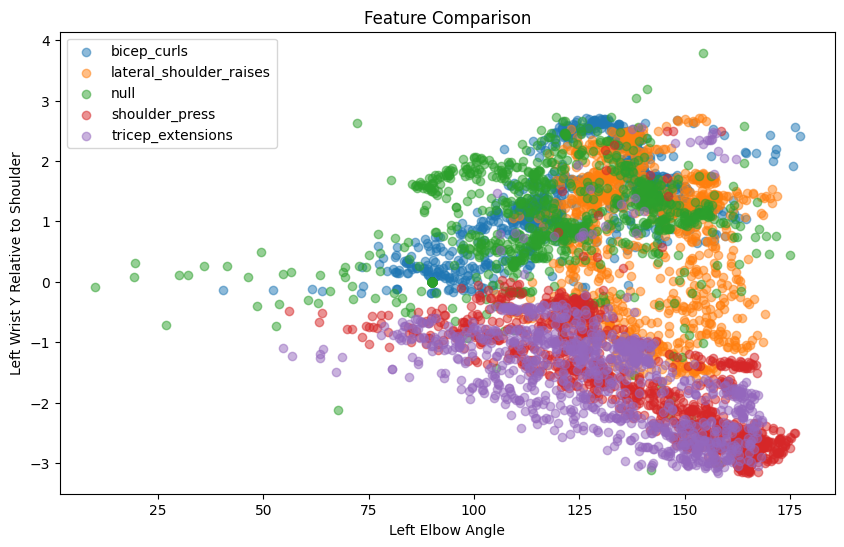

In [6]:
plt.figure(figsize=(10, 6))
for label, name in enumerate(directories):
    subset = df[df['label'] == label].sample(min(1000, len(df[df['label'] == label])))
    plt.scatter(subset['l_elbow_angle'], subset['l_wrist_y_rel'], label=name, alpha=0.5)

plt.xlabel('Left Elbow Angle')
plt.ylabel('Left Wrist Y Relative to Shoulder')
plt.title('Feature Comparison')
plt.legend()
plt.show()
# todo: maybe we need to delete outliers and invalid skeleton frames

In [7]:
print("\nframes per label:", df['label'].value_counts())
directories


frames per label: label
1    22154
0    19835
4    19756
2    18014
3    17826
Name: count, dtype: int64


['bicep_curls',
 'lateral_shoulder_raises',
 'null',
 'shoulder_press',
 'tricep_extensions']

In [8]:
print("Subjects available:", df['subject'].unique())
print("Frames per subject:\n", df['subject'].value_counts())
print("\nLabels per subject:\n", df.groupby(['subject', 'label']).size())

Subjects available: ['w00' 'w01' 'w02' 'w13' 'w14' 'w15' 'w16' 'w17' 'w18' 'w19' 'w20']
Frames per subject:
 subject
w16    11790
w15    11215
w14    10508
w02     9803
w20     9496
w01     9080
w13     8822
w19     7848
w17     6667
w18     6625
w00     5731
Name: count, dtype: int64

Labels per subject:
 subject  label
w00      0        1427
         1        1269
         2         500
         3        1494
         4        1041
w01      0        1484
         1        2100
         2        1000
         3        2030
         4        2466
w02      0        1764
         1        2850
         2        2614
         3         772
         4        1803
w13      0        1392
         1        1480
         2        3000
         3        1520
         4        1430
w14      0        1750
         1        1979
         2        2900
         3        2005
         4        1874
w15      0        1655
         1        2407
         2        3000
         3        2382
         4

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

train_subjects = ['w01', 'w02', 'w13', 'w14', 'w15', 'w16', 'w17', 'w18', 'w20']
test_subjects = ['w00', 'w19']

train_df = df[df['subject'].isin(train_subjects)]
test_df = df[df['subject'].isin(test_subjects)]

feature_cols = [c for c in df.columns if c not in ['label', 'subject', 'file', 'frame']]

X_train = train_df[feature_cols]
y_train = train_df['label']

X_test = test_df[feature_cols]
y_test = test_df['label']

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9015391413211576

Confusion Matrix:
 [[3427   32  495    0    0]
 [  29 1594   72    0    0]
 [ 199   57  917    8   19]
 [   0    0   48 3477  363]
 [   0    4    0   11 2827]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.87      0.90      3954
           1       0.94      0.94      0.94      1695
           2       0.60      0.76      0.67      1200
           3       0.99      0.89      0.94      3888
           4       0.88      0.99      0.93      2842

    accuracy                           0.90     13579
   macro avg       0.87      0.89      0.88     13579
weighted avg       0.91      0.90      0.90     13579



In [10]:
print("\nframes per label:", df['label'].value_counts())
directories


frames per label: label
1    22154
0    19835
4    19756
2    18014
3    17826
Name: count, dtype: int64


['bicep_curls',
 'lateral_shoulder_raises',
 'null',
 'shoulder_press',
 'tricep_extensions']

In [ ]:
X = df[feature_cols]
y = df['label']
prod_clf = RandomForestClassifier(n_estimators=100, random_state=42)
prod_clf.fit(X, y)

Accuracy: 0.9015391413211576

Confusion Matrix:
 [[3427   32  495    0    0]
 [  29 1594   72    0    0]
 [ 199   57  917    8   19]
 [   0    0   48 3477  363]
 [   0    4    0   11 2827]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.87      0.90      3954
           1       0.94      0.94      0.94      1695
           2       0.60      0.76      0.67      1200
           3       0.99      0.89      0.94      3888
           4       0.88      0.99      0.93      2842

    accuracy                           0.90     13579
   macro avg       0.87      0.89      0.88     13579
weighted avg       0.91      0.90      0.90     13579



In [12]:
import joblib

model_dir = '../models'
os.makedirs(model_dir, exist_ok=True)
model_filename = os.path.join(model_dir, 'exercise_classifier_rf.joblib')
joblib.dump(prod_clf, model_filename)
print(f"Model saved to {model_filename}")


Model saved to ../models/exercise_classifier_rf.joblib


In [13]:
# Setup paths for testing
bicep_curls_path = os.path.join(dataset_dir, 'bicep_curls')
shoulder_press_path = os.path.join(dataset_dir, 'shoulder_press')
null_path = os.path.join(dataset_dir, 'null')

bicep_files = sorted([f for f in os.listdir(bicep_curls_path) if f.endswith('.json')])
press_files = sorted([f for f in os.listdir(shoulder_press_path) if f.endswith('.json')])
null_files = sorted([f for f in os.listdir(null_path) if f.endswith('.json')])

def predict_exercise(json_file_path, model):
    with open(json_file_path, 'r') as f:
        frames = json.load(f)
    
    skeleton_arr = skeleton_to_numpy(frames)
    # Apply smoothing and normalization
    smoothed_arr = smooth_skeleton(skeleton_arr, window_size=5)
    normalized_arr = normalize_skeleton(smoothed_arr)
    
    # Extract comprehensive features
    X = extract_features_from_clip(normalized_arr)
    
    predictions = model.predict(X)
    
    # Majority vote for the whole clip
    final_prediction = np.bincount(predictions).argmax()
    # Updated label map based on directory order: ['bicep_curls', 'lateral_shoulder_raises', 'null', 'shoulder_press']
    label_map = {0: 'Bicep Curl', 1: 'Lateral Raise', 2: 'Null/Unknown', 3: 'Shoulder Press'}
    
    return label_map.get(final_prediction, "Unknown"), predictions

# Test on a file from bicep curls
if bicep_files:
    test_file = os.path.join(bicep_curls_path, bicep_files[0])
    prediction, frame_preds = predict_exercise(test_file, clf)
    print(f"Prediction for {bicep_files[0]}: {prediction}")

# Test on a file from shoulder press
if press_files:
    test_file_press = os.path.join(shoulder_press_path, press_files[0])
    prediction_press, frame_preds_press = predict_exercise(test_file_press, clf)
    print(f"Prediction for {press_files[0]}: {prediction_press}")

# Test on a file from null
if null_files:
    test_file_null = os.path.join(null_path, null_files[0])
    prediction_null, frame_preds_null = predict_exercise(test_file_null, clf)
    print(f"Prediction for {null_files[0]}: {prediction_null}")

Prediction for w00_rgb_bicep_curls_1_skeleton.json: Bicep Curl
Prediction for w00_rgb_dumbbell_shoulder_press_2_skeleton.json: Shoulder Press
Prediction for w00_rgb_24741-25241_null_1_skeleton.json: Null/Unknown


In [14]:
# Integrate smoothing into inference
def predict_exercise_smoothed(json_file_path, model):
    with open(json_file_path, 'r') as f:
        frames = json.load(f)
    
    skeleton_arr = skeleton_to_numpy(frames)
    smoothed_arr = smooth_skeleton(skeleton_arr, window_size=5)
    normalized_arr = normalize_skeleton(smoothed_arr)
    
    # Extract comprehensive features
    X = extract_features_from_clip(normalized_arr)
    
    predictions = model.predict(X)
    
    final_prediction = np.bincount(predictions).argmax()
    # Updated label map based on directory order: ['bicep_curls', 'lateral_shoulder_raises', 'null', 'shoulder_press']
    label_map = {0: 'Bicep Curl', 1: 'Lateral Raise', 2: 'Null/Unknown', 3: 'Shoulder Press'}
    
    return label_map.get(final_prediction, "Unknown")

if bicep_files:
    print("Smoothed Prediction (Bicep):", predict_exercise_smoothed(os.path.join(bicep_curls_path, bicep_files[0]), clf))

Smoothed Prediction (Bicep): Bicep Curl
